In [17]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

In [18]:
# constants
R = 8.314 

In [19]:
# define Toth model functions
def get_qs(T):
    return qs0 * np.exp(chi * (1 - T / T0)) # eq 9

def get_b(T):
    exponent = (-dH / (R * T0)) * ((T0 / T) - 1)
    return b0 * np.exp(exponent) # eq 10

def get_t(T):
    return t0 + alpha * (1 - (T0 / T)) # eq 11

def toth_isotherm(pressure, T):
    qs_val = get_qs(T)
    b_val = get_b(T)
    t_val = get_t(T)
    
    numerator = qs_val * b_val * pressure
    denominator = (1 + (b_val * pressure)**t_val)**(1 / t_val)
    
    return numerator / denominator # eq 8 (mol/kg) 


# define GAB isotherm equation for H2O
def gab_isotherm(x_h2o, params_gab): # x_h2o is RH from 0 to 1
    q_m, c, k_G = params_gab
    
    numerator = q_m * c * k_G * x_h2o
    
    term1 = 1 - k_G * x_h2o
    term2 = 1 + (c - 1) * k_G * x_h2o
    denominator = term1 * term2
    
    return numerator / denominator # eq 12


# define WADST model
import numpy as np

def wadst_model(P_co2, q_h2o, params_dry, params_wet, A):
    qs_d, b_d, t_d = params_dry
    qs_w, b_w, t_w = params_wet

    if q_h2o > 1e-9:
        weight = np.exp(-A / q_h2o)
    else:
        weight = 0.0

    # dry Toth term
    dry_term = (qs_d * b_d * P_co2) / ((1 + (b_d * P_co2)**t_d)**(1/t_d))

    # wet Toth term
    wet_term = (qs_w * b_w * P_co2) / ((1 + (b_w * P_co2)**t_w)**(1/t_w))

    q_total = (1 - weight) * dry_term + weight * wet_term # eq 13
    
    return q_total


# define CATSO model
def catso_model(P_co2, x_h2o, params_dry, params_wet, water_params):    
    qs_d, b_d, t_d = params_dry
    qs_w, b_w, t_w = params_wet
    b_h2o, S, K, x_m = water_params

    # competitive term (equation 15)
    denom_comp = (1 + (b_d * P_co2)**t_d + (b_h2o * x_h2o)**t_d)**(1/t_d)
    q_comp = (qs_d * b_d * P_co2) / denom_comp

    # theta function (equations 17 and 18)
    w_x = 1 / (1 + np.exp(-S * (x_h2o - x_m))) # eq 17
    theta_m = (1 - w_x) * K * x_h2o + w_x # eq 18

    # Toth isotherm for the wet sites
    denom_wet = (1 + (b_w * P_co2)**t_w)**(1/t_w)
    base_wet_q = (qs_w * b_w * P_co2) / denom_wet
    q_wet = theta_m * base_wet_q # eq 16

    # Total uptake
    q_total = q_comp + q_wet # eq 14
    
    return q_total

In [39]:
T0 = 313 #K

def toth_model(x, pressure, T):            
    qs_val = x[0] * np.exp(x[1] * (1.0 - T / T0))
    b_val  = x[2] * np.exp((-53.97 / (R * T0)) * ((T0 / T) - 1.0))
    t_val  = x[3] + x[4] * (1.0 - T0 / T)

    q_star = (qs_val * b_val * pressure)/((1 + (b_val * pressure)**t_val)**(1 / t_val))

    return q_star

def residuals_toth(x, pressure, T, y_Toth):            
    q_pred = toth_model(x, pressure, T)
    return q_pred - y_Toth

In [42]:
# load in my .csv
dry_co2 = pd.read_csv('dry_co2.csv')

pressures = dry_co2['pCO2 (bar)'].values * 100 # to put in kPa
Temps = dry_co2['Temp (K)'].values
y_values = dry_co2['CO2 Adsorption (mmol/g)'].values

x0 = [2.0, 0.5, 3000.0, 0.25, 0.2]

results = least_squares(residuals_toth, x0, args=(pressures, Temps, y_values),
                       bounds=([1, 0, 0, 0, 0,], [5, 5, 10000, 1, 2.5]))


print("Success:", results.success)
print("Fitted Dry Parameters (x):", results.x)


Success: True
Fitted Dry Parameters (x): [2.85377839e+00 5.00000000e+00 1.37786162e+00 8.25520148e-01
 2.73649423e-95]


In [29]:
params_fitted = results.x
print(f"qs0 (Sat Capacity) : {params_fitted[0]:.4f} mmol/g")
print(f"chi (Temp dep qs)  : {params_fitted[1]:.4f}")
print(f"b0 (Affinity)      : {params_fitted[2]:.4f} kPa-1")
print(f"t0 (Heterogeneity) : {params_fitted[3]:.4f}")
print(f"alpha (Temp dep t) : {params_fitted[4]:.4f}")


qs0 (Sat Capacity) : 2.8538 mmol/g
chi (Temp dep qs)  : 5.0000
b0 (Affinity)      : 1.3779 kPa-1
t0 (Heterogeneity) : 0.8255
alpha (Temp dep t) : 0.0000


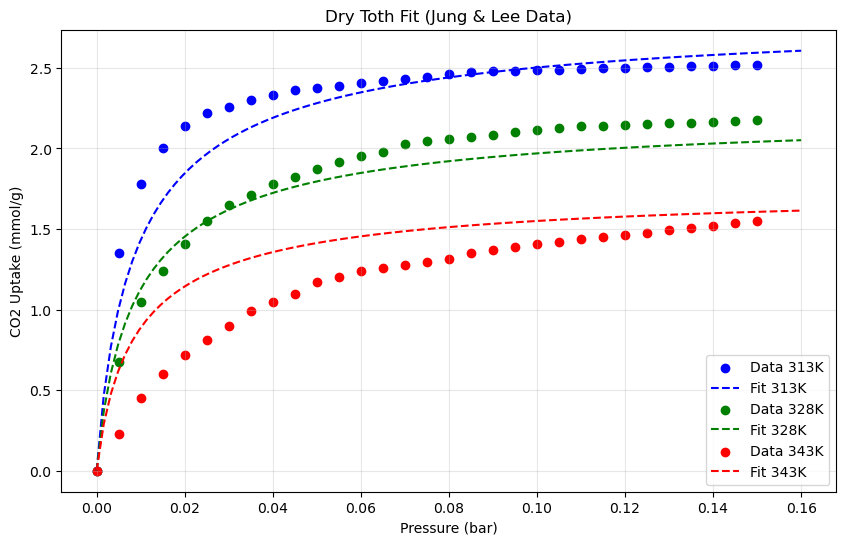

In [41]:
plt.figure(figsize=(10, 6))
colors = {313: 'blue', 328: 'green', 343: 'red'}

p_bar = np.linspace(0, 0.16, 100)
p_kPa = p_bar * 100

for T_val in [313, 328, 343]:
    # Raw data points
    subset = dry_co2[dry_co2['Temp (K)'] == T_val]
    plt.scatter(subset['pCO2 (bar)'], subset['CO2 Adsorption (mmol/g)'], 
                color=colors[T_val], label=f'Data {T_val}K')
    
    # Fitted curve
    q_pred_curve = toth_model(params_fitted, p_kPa, T_val)
    plt.plot(p_bar, q_pred_curve, color=colors[T_val], linestyle='--', label=f'Fit {T_val}K')

plt.xlabel('Pressure (bar)')
plt.ylabel('CO2 Uptake (mmol/g)')
plt.title('Dry Toth Fit (Jung & Lee Data)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
#run this
#check that x0 is within reasonable bounds
# dry fit parameters
# hold those constant
# fit GAB to get H2o parameters
# load in humidity curves (both humidities, need a new input in function RH)
# refit to get wet parameters


def residuals_GAB(x,pressure,T):
    # replace with GAB:           
    qs_val = x[0] * np.exp(x[1] * (1.0 - T / T0))
    b_val  = x[2] * np.exp((deltaH / (R * T0)) * ((T0 / T) - 1.0))
    t_val  = x[3] + x[4] * (1.0 - T0 / T)

    q_h2o = (qs_val * b_val * pressure)/((1 + (b_val * pressure)**t_val)**(1 / t_val))

    return y_GAB - q_h2o

SyntaxError: expected ':' (1621953211.py, line 10)